In [2]:
import re
import random
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import pipeline


In [3]:
dataset = load_dataset("yelp_polarity")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [4]:
for i in range(5):
    row = dataset["train"][i]
    print(f"Label: {row['label']} | Review: {row['text']}")


Label: 0 | Review: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
Label: 1 | Review: Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very p

In [5]:
def traditional_clean(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text) # remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # remove emojis & symbols
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

traditional_examples = [traditional_clean(dataset['train'][i]['text']) for i in range(5)]
traditional_examples


['unfortunately the frustration of being dr goldbergs patient is a repeat of the experience ive had with so many other doctors in nyc good doctor terrible staff it seems that his staff simply never answers the phone it usually takes 2 hours of repeated calling to get an answer who has time for that or wants to deal with it i have run into this problem with many other doctors and i just dont get it you have office workers you have patients with medical needs why isnt anyone answering the phone its incomprehensible and not work the aggravation its with regret that i feel that i have to give dr goldberg 2 stars',
 'been going to dr goldberg for over 10 years i think i was one of his 1st patients when he started at mhmg hes been great over the years and is really all about the big picture it is because of him not my now former gyn dr markoff that i found out i have fibroids he explores all options with you and is very patient and understanding he doesnt judge and asks all the right questio

In [6]:
def simple_tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def corpus_stats(texts):
    all_tokens = []
    lengths = []
    for t in texts:
        tokens = simple_tokenize(t)
        all_tokens.extend(tokens)
        lengths.append(len(tokens))
    vocab = set(all_tokens)
    return {
        "vocab_size": len(vocab),
        "avg_length": sum(lengths) / len(lengths)
    }

subset = dataset['train'].select(range(250))  # time-efficient
raw_texts = [row["text"] for row in subset]

raw_stats = corpus_stats(raw_texts)
raw_stats


{'vocab_size': 4350, 'avg_length': 148.06}

In [7]:
cleaner = pipeline("text2text-generation", model="google/flan-t5-base", max_length=128)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [8]:
def llm_clean(text):
    prompt = (
        "Rewrite this review into professional, clear and grammatically correct English. "
        "Correct spelling mistakes, expand abbreviations, and remove emojis or informal language "
        "while keeping the meaning the same: " + text
    )
    result = cleaner(prompt)[0]['generated_text']
    return result.strip()

cleaned_texts = []
for i, row in enumerate(subset):
    cleaned_texts.append(llm_clean(row["text"]))
    if (i+1) % 30 == 0:
        print(f"Processed {i+1}/{len(subset)}")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (1142 > 512). Running this sequence through the model will result in indexing errors


Processed 30/250
Processed 60/250
Processed 90/250
Processed 120/250
Processed 150/250
Processed 180/250
Processed 210/250
Processed 240/250


In [9]:
clean_stats = corpus_stats(cleaned_texts)
raw_stats, clean_stats


({'vocab_size': 4350, 'avg_length': 148.06},
 {'vocab_size': 2840, 'avg_length': 70.984})

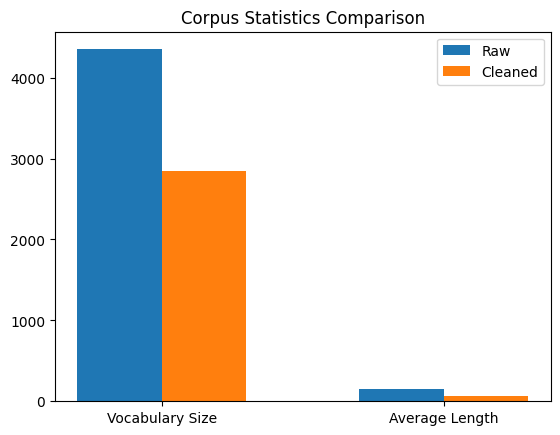

In [10]:
labels = ["Vocabulary Size", "Average Length"]
before = [raw_stats["vocab_size"], raw_stats["avg_length"]]
after = [clean_stats["vocab_size"], clean_stats["avg_length"]]

plt.figure()
x = range(len(labels))
plt.bar([i - 0.15 for i in x], before, width=0.3, label="Raw")
plt.bar([i + 0.15 for i in x], after, width=0.3, label="Cleaned")
plt.xticks(x, labels)
plt.title("Corpus Statistics Comparison")
plt.legend()
plt.show()


In [11]:
for i in random.sample(range(len(subset)), 5):
    print("Original:", subset[i]["text"])
    print("Cleaned :", cleaned_texts[i])
    print()


Original: Terrible service.  Food unremarkable.  Waiter disappeared for 45 minutes to serve larger group due to staffing mismanagement.  Saved his tip by discounting meal after I complained.  All and all, a very crude and unpleasant dining experience for me and my guests.  Not to be repeated, never again!
Cleaned : Terrible service. Food unremarkable. Waiter disappeared for 45 minutes to serve larger group due to staffing mismanagement. Saved his tip by discounting meal after I complained. All and all, a very crude and unpleasant dining experience for me and my guests. Not to be repeated, never again!

Original: Italian dinners, American, endless soup and salad bar is great. Most food for your dollar. I highly recommend. Great bar. Good place to watch a game. The bar can get quite noisy in the evenings, but it adds to the great atmosphere at Rocky's
Cleaned : Great place to watch a game. I highly recommend. Great bar. Good place to watch a game. The bar can get quite noisy in the eveni

In [12]:
import pandas as pd
df = pd.DataFrame({
    "label": [row["label"] for row in subset],
    "text_raw": raw_texts,
    "text_clean": cleaned_texts
})
df.to_csv("yelp_cleaned_llm.csv", index=False)
"CSV saved successfully!"


'CSV saved successfully!'